### Modules

In [1]:
import re
from typing import Dict, List, Optional, Text, Tuple
import os
import time
from time import sleep
from tqdm import tqdm_notebook as tqdm
from scipy.ndimage import zoom

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image

import tensorflow as tf
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from torchvision import datasets, models, transforms
import torchvision.models
from torchvision.transforms.functional import F_pil

### Load Data

In [4]:
train_data = torch.load('loaded_training.npy')
val_data = torch.load('loaded_val.npy')
test_data = torch.load('loaded_test.npy')

### Vanilla Predicter

In [5]:
class FirePrediction(nn.Module):

    def __init__(self):
        self.name = 'FirePrediction'
        super(FirePrediction, self).__init__()
        self.rnn = nn.GRU(9216, 9216, 1) #512, 256 smaller hidden size
        kernel_size = 4
        stride = 2
        padding = 1
        out_padding = 0
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 182, 3, stride, padding, out_padding),
            nn.ConvTranspose2d(182, 128, 6, stride, padding, out_padding),
            nn.ConvTranspose2d(128, 64, 8, stride, padding, out_padding),
            nn.ConvTranspose2d(64, 32, 9, stride, padding, out_padding),
            nn.ConvTranspose2d(32, 3, 10, stride, padding, out_padding),
        )

    def forward(self, x):
        x = np.array(x)

        if len(x.shape) ==  2:
          print(True)
          x = np.expand_dims(x, axis=1)

        rnn_input = torch.from_numpy(x[0:10, :, :])
        h0 = x[11,:,:]
        h0 = torch.from_numpy(h0[np.newaxis, ...])

        out, h = self.rnn(rnn_input, h0)
    
        output_array = []
    
        for i in range(h.shape[1]):
            decoder_input = h[:,i,:]
            decoder_input = decoder_input[0,:]
            decoder_input = torch.reshape(decoder_input, (256, 6, 6))
            decoder_input = decoder_input[np.newaxis, ...]
            output = self.decoder(decoder_input)
            output = F.relu(output)
            
            if i == 0:
                output_array = output
            else:
                output_array = torch.cat((output_array, output), 0)

        return output_array

### Deep Predicter

In [6]:
class DeepFirePrediction(nn.Module):

    def __init__(self):
        self.name = 'DeepFirePrediction'
        super(DeepFirePrediction, self).__init__()
        self.rnn_1 = nn.GRU(9216, 9216, 1) #512, 256 smaller hidden size\
        self.rnn_2 = nn.GRU(9216, 9216, 1)
        kernel_size = 4
        stride = 2
        padding = 1
        out_padding = 0
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 182, 3, stride, padding, out_padding),
            nn.ConvTranspose2d(182, 128, 6, stride, padding, out_padding),
            nn.ConvTranspose2d(128, 64, 8, stride, padding, out_padding),
            nn.ConvTranspose2d(64, 32, 9, stride, padding, out_padding),
            nn.ConvTranspose2d(32, 3, 10, stride, padding, out_padding),
        )

    def forward(self, x):
        x = np.array(x)

        if len(x.shape) ==  2:
          print(True)
          x = np.expand_dims(x, axis=1)

        rnn_input = torch.from_numpy(x[0:10, :, :])
        h0 = x[11,:,:]
        h0 = torch.from_numpy(h0[np.newaxis, ...])

        out, h = self.rnn_1(rnn_input, h0)
        out, h = self.rnn_2(out, h)
        
        output_array = []
    
        for i in range(h.shape[1]):
            decoder_input = h[:,i,:]
            decoder_input = decoder_input[0,:]
            decoder_input = torch.reshape(decoder_input, (256, 6, 6))
            decoder_input = decoder_input[np.newaxis, ...]
            output = self.decoder(decoder_input)
            output = F.relu(output)
            
            if i == 0:
                output_array = output
            else:
                output_array = torch.cat((output_array, output), 0)

        return output_array

### Upsample Predicter

In [99]:
class UpsampleFirePrediction(nn.Module):

    def __init__(self):
        self.name = 'FirePrediction'
        super(UpsampleFirePrediction, self).__init__()
        self.rnn = nn.GRU(9216, 9216, 1) #512, 256 smaller hidden size
        kernel_size = 4
        stride = 2
        padding = 1
        out_padding = 0
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, stride, padding, out_padding),
            nn.Upsample(scale_factor=1.75, mode='bilinear'),
            nn.ConvTranspose2d(128, 64, 2, stride, padding, out_padding),
            nn.Upsample(scale_factor=1.75, mode='bilinear'),
            nn.ConvTranspose2d(64, 3, 4, stride, padding, out_padding),
            nn.Upsample(scale_factor=2, mode='bilinear')
        )

    def forward(self, x):
        x = np.array(x)

        if len(x.shape) ==  2:
          print(True)
          x = np.expand_dims(x, axis=1)

        rnn_input = torch.from_numpy(x[0:10, :, :])
        h0 = x[11,:,:]
        h0 = torch.from_numpy(h0[np.newaxis, ...])

        out, h = self.rnn(rnn_input, h0)
    
        output_array = []
    
        for i in range(h.shape[1]):
            decoder_input = h[:,i,:]
            decoder_input = decoder_input[0,:]
            decoder_input = torch.reshape(decoder_input, (256, 6, 6))
            decoder_input = decoder_input[np.newaxis, ...]
            output = self.decoder(decoder_input)
            output = F.relu(output)
            
            if i == 0:
                output_array = output
            else:
                output_array = torch.cat((output_array, output), 0)

        return output_array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


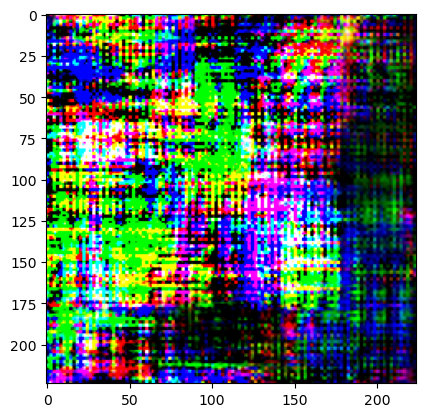

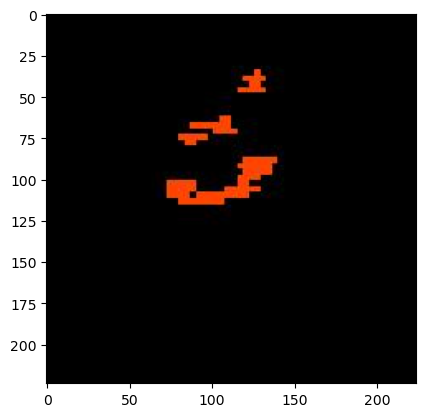

In [100]:
deep = UpsampleFirePrediction()
data = train_data[66][0]
label = train_data[66][1]
output = deep.forward(data)
output.shape
image_viewer(output)
image_viewer(label)

### Training

In [82]:
def image_viewer(image_array):
    if len(image_array.shape) == 4:
        image_array = image_array[0,:,:,:]
        image_array = np.array(image_array.detach().numpy())
        image_array = np.transpose(image_array, (1, 2, 0))
    elif len(image_array.shape) == 3:
        image_array = np.array(image_array.detach().numpy())
        #image_array = np.transpose(image_array, (0, =))
    else:
        raise Typererror('Incorrect dimension')
        
    plt.imshow(image_array)
    plt.show()
    return

def drop_last(batch_size, data_loader):
    output = data_loader
    counter = -1
    length = len(data_loader)

    if batch_size > len(output):
        batch_size = len(output)

    while len(output) % batch_size != 0:
        
        #print('not the right size, counter at', length)
        output = output[:length]
        length -= 1
        #print('output size', len(output))
        if len(output) % batch_size == 0:
            break
    #print(counter, 'items is neglected')
    

    return output

def concat_batch(batch_size, data_loader):
    batched_set = []
    for i in range(0, len(data_loader), batch_size):
        batched_data = []
        batched_label = []
        for j in range(0, batch_size, 1):
            if j == 0:
                batched_data = data_loader[i][0]
                label = data_loader[i][1]
                label = Image.fromarray(np.array(label))
                #label = label.resize((64, 64))
                label = np.array(label)
                batched_label = label[np.newaxis, ...]
            else:
                batched_data = np.concatenate((batched_data, data_loader[j+i][0]), axis=1)
                label = data_loader[j+i][1]
                label = Image.fromarray(np.array(label))
                #label = label.resize((64, 64))
                label = np.array(label)
                batched_label = np.concatenate((batched_label, label[np.newaxis, ...]), axis=0)
            #print('batch data shape', batched_data.shape)
            #print('batch label shape', batched_label.shape)
            if i+j == len(data_loader)-1:
                break
        batched_set.append((batched_data, batched_label))
        
    return batched_set

def get_accuracy(model, data_loader, use_cuda=True):
    accuracies = []
    counter = 0
    
    for features, labels in tqdm(data_loader, desc='Accuracy', unit='batch'):
        recon = model(features)
        recon = torch.transpose(recon, 1, 2) #give 0 3 1 3
        recon = torch.transpose(recon, 2, 3) # give 0 2 3 1
        difference = np.array(recon.detach().numpy()) - np.array(labels)
        squared_difference = np.square(difference)
        mse = np.mean(squared_difference)/(255**2)
        accuracies.append(mse)
        counter += 1
        
    sigma = 0
    for item in accuracies:
        sigma += item
        #print('sigma is', sigma, 'number of error calculated is', counter, 'the average is', float(sigma)/float(counter))

    acc_sum = float(sigma)
    item_num = int(counter)

    number = (acc_sum, item_num)

    return number[1]/number[0]

def get_model_name(name, learning_rate, epoch):
    path = "model_{0}_lr{1}_epoch{2}".format(name, learning_rate, epoch)
    return path

def get_val_loss(model, valid_loader, criterion, use_cuda=True):
    total_val_loss = 0.0
    i = 0

    for data,label in tqdm(valid_loader, desc='Loss', unit='batch'):
        label = torch.from_numpy(label)
        '''
        #############################################
        # To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
            data = torch.from_numpy(data).cuda()
            label = label.cuda()
        #############################################
        '''

        recon = model(data)

        #0 1 2 3
        recon = torch.transpose(recon, 1, 2) #give 0 3 1 3
        recon = torch.transpose(recon, 2, 3) # give 0 2 3 1
        '''
        recon = torch.from_numpy(recon).detach()
        label = torch.from_numpy(label).detach()
        '''
        loss = criterion(recon, label.float())
        #loss.requires_grad=True
        total_val_loss += loss.item()
        i += 1
    val_loss = float(total_val_loss)/i
    return val_loss

def train(model, train_loader, valid_loader, batch_size=90, num_epochs=5, learning_rate=1e-4, use_cuda=True):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    print('Loading dataset into batch_size of', batch_size)
    train_loader = drop_last(batch_size, train_loader)
    train_loader = concat_batch(batch_size, train_loader)
    valid_loader = drop_last(batch_size, valid_loader)
    valid_loader = concat_batch(batch_size, valid_loader)

    start_time = time.time()
    for epoch in tqdm(range(num_epochs), desc='Epoch', unit='epoch'):
        total_train_loss = 0.0
        i = 0
        for data,label in tqdm(train_loader, desc='Training', unit='batch'):
            label = torch.from_numpy(label)

            '''
            #############################################
            # To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                data = data.cuda()
                label = label.cuda()
            #############################################
            '''
            recon = model(data)

            #0 1 2 3
            recon = torch.transpose(recon, 1, 2) #give 0 3 1 3
            recon = torch.transpose(recon, 2, 3) # give 0 2 3 1
            '''
            recon = torch.from_numpy(recon).detach()
            label = torch.from_numpy(label).detach()
            '''
            optimizer.zero_grad()
            #print('recon size', recon.size)
            #print('label size', label.size, 'label type is', type(label))
            loss = criterion(recon, label.float())
            #loss.requires_grad=True
            total_train_loss += loss.item()
            i += 1
            loss.backward()
            optimizer.step()
            
        print('Calculating epoch', epoch, 'training error')
        train_err[epoch] = get_accuracy(model, train_loader)
        
        print('Calculating epoch', epoch, 'training loss')
        train_loss[epoch] = float(total_train_loss)/(i + 1)
        #print('The shape of train_loader[1][0]:', train_loader[1][0].shape)
        #print('The shape of valid_loader[1][0]:', valid_loader[1][0].shape)
        
        print('Calculating epoch', epoch, 'validation error')
        val_err[epoch] = get_accuracy(model, valid_loader)
        
        print('Calculating epoch', epoch, 'validation loss')
        val_loss[epoch] = get_val_loss(model, valid_loader, criterion)
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        if (epoch + 1) % 20 == 0:
            model_path = get_model_name(model.name, learning_rate, epoch)
            torch.save(model.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Plotting
    plt.title("Train vs Validation Loss")
    plt.plot(range(1 ,num_epochs+1), train_loss, label="Train")
    plt.plot(range(1 ,num_epochs+1), val_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(range(1 ,num_epochs+1), train_err, label="Train")
    plt.plot(range(1 ,num_epochs+1), val_err, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_err[-1]))
    print("Final Validation Accuracy: {}".format(val_err[-1]))
    
def load_model(model, model_path):
    state = torch.load(model_path)
    model.load_state_dict(state)
    return 'All parameters loaded'

### Epoch = 300, Bs = 128, Vanilla Fire Prediction

Loading dataset into batch_size of 128


C:\Users\audre\AppData\Local\Temp\ipykernel_237868\1412368302.py:129: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(num_epochs), desc='Epoch', unit='epoch'):


Epoch:   0%|          | 0/300 [00:00<?, ?epoch/s]

C:\Users\audre\AppData\Local\Temp\ipykernel_237868\1412368302.py:132: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data,label in tqdm(train_loader, desc='Training', unit='batch'):


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 0 training error


C:\Users\audre\AppData\Local\Temp\ipykernel_237868\1412368302.py:54: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for features, labels in tqdm(data_loader, desc='Accuracy', unit='batch'):


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 0 training loss
Calculating epoch 0 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 0 validation loss


C:\Users\audre\AppData\Local\Temp\ipykernel_237868\1412368302.py:84: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data,label in tqdm(valid_loader, desc='Loss', unit='batch'):


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 1: Train acc: 30.411215091639786, Train loss: 1604.9212341308594 |Validation acc: 22.155945204084663, Validation loss: 2934.881591796875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 1 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 1 training loss
Calculating epoch 1 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 1 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 2: Train acc: 30.577461534843707, Train loss: 1601.8206787109375 |Validation acc: 22.22662474294907, Validation loss: 2925.547607421875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 2 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 2 training loss
Calculating epoch 2 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 2 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 3: Train acc: 30.818469215431872, Train loss: 1589.5716247558594 |Validation acc: 22.45520886342965, Validation loss: 2895.76904296875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 3 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 3 training loss
Calculating epoch 3 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 3 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 4: Train acc: 31.028529878495988, Train loss: 1580.0907897949219 |Validation acc: 22.571923522598546, Validation loss: 2880.793701171875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 4 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 4 training loss
Calculating epoch 4 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 4 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 5: Train acc: 31.202207869608415, Train loss: 1570.0738220214844 |Validation acc: 22.643790472095056, Validation loss: 2871.650634765625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 5 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 5 training loss
Calculating epoch 5 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 5 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 6: Train acc: 31.485570248496625, Train loss: 1560.2803344726562 |Validation acc: 22.888986151832686, Validation loss: 2840.885498046875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 6 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 6 training loss
Calculating epoch 6 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 6 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 7: Train acc: 31.918995781882515, Train loss: 1544.3971252441406 |Validation acc: 23.242639220923945, Validation loss: 2797.66259765625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 7 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 7 training loss
Calculating epoch 7 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 7 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 8: Train acc: 32.5623140071032, Train loss: 1521.4044189453125 |Validation acc: 23.610550170327034, Validation loss: 2754.066162109375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 8 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 8 training loss
Calculating epoch 8 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 8 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 9: Train acc: 33.51256492812208, Train loss: 1489.1805114746094 |Validation acc: 24.17016645720406, Validation loss: 2690.2998046875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 9 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 9 training loss
Calculating epoch 9 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 9 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 10: Train acc: 34.88724446563708, Train loss: 1443.6179504394531 |Validation acc: 24.81011361185852, Validation loss: 2620.90576171875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 10 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 10 training loss
Calculating epoch 10 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 10 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 11: Train acc: 36.79013457548071, Train loss: 1384.322265625 |Validation acc: 25.486871996463222, Validation loss: 2551.314697265625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 11 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 11 training loss
Calculating epoch 11 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 11 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 12: Train acc: 39.467746896867595, Train loss: 1311.421142578125 |Validation acc: 26.889116558030256, Validation loss: 2418.263671875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 12 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 12 training loss
Calculating epoch 12 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 12 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 13: Train acc: 43.21126188840468, Train loss: 1220.8372497558594 |Validation acc: 28.743839485762518, Validation loss: 2262.2255859375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 13 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 13 training loss
Calculating epoch 13 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 13 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 14: Train acc: 48.217740039343795, Train loss: 1111.2254638671875 |Validation acc: 31.09065293868459, Validation loss: 2091.464111328125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 14 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 14 training loss
Calculating epoch 14 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 14 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 15: Train acc: 53.97569929884812, Train loss: 1003.5322723388672 |Validation acc: 34.950291354782024, Validation loss: 1860.5006103515625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 15 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 15 training loss
Calculating epoch 15 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 15 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 16: Train acc: 60.62590320463192, Train loss: 897.291748046875 |Validation acc: 39.49952591059683, Validation loss: 1646.22216796875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 16 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 16 training loss
Calculating epoch 16 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 16 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 17: Train acc: 67.28008607347732, Train loss: 802.4104461669922 |Validation acc: 46.15860138999672, Validation loss: 1408.7305908203125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 17 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 17 training loss
Calculating epoch 17 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 17 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 18: Train acc: 73.62755231668832, Train loss: 725.5652465820312 |Validation acc: 52.649849532972524, Validation loss: 1235.04638671875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 18 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 18 training loss
Calculating epoch 18 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 18 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 19: Train acc: 79.07941824568778, Train loss: 665.2791290283203 |Validation acc: 59.22896299991083, Validation loss: 1097.85888671875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 19 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 19 training loss
Calculating epoch 19 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 19 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 20: Train acc: 80.75899347499148, Train loss: 618.9085693359375 |Validation acc: 61.00036816553363, Validation loss: 1065.9774169921875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 20 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 20 training loss
Calculating epoch 20 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 20 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 21: Train acc: 81.57394373952907, Train loss: 609.3120574951172 |Validation acc: 55.0845059935969, Validation loss: 1180.4593505859375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 21 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 21 training loss
Calculating epoch 21 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 21 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 22: Train acc: 84.45175606639437, Train loss: 606.9360046386719 |Validation acc: 61.65087157978067, Validation loss: 1054.7301025390625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 22 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 22 training loss
Calculating epoch 22 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 22 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 23: Train acc: 90.51843974292619, Train loss: 592.9270172119141 |Validation acc: 68.9908942243053, Validation loss: 942.5158081054688


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 23 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 23 training loss
Calculating epoch 23 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 23 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 24: Train acc: 90.11024144719113, Train loss: 559.5258178710938 |Validation acc: 72.74608393119202, Validation loss: 893.8619384765625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 24 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 24 training loss
Calculating epoch 24 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 24 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 25: Train acc: 91.59344646553897, Train loss: 542.7092895507812 |Validation acc: 70.76372471182421, Validation loss: 918.9038696289062


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 25 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 25 training loss
Calculating epoch 25 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 25 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 26: Train acc: 93.82560468778568, Train loss: 533.0285339355469 |Validation acc: 76.79622440707571, Validation loss: 846.7213134765625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 26 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 26 training loss
Calculating epoch 26 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 26 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 27: Train acc: 95.92226887219148, Train loss: 519.4221649169922 |Validation acc: 76.82418477616187, Validation loss: 846.4132690429688


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 27 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 27 training loss
Calculating epoch 27 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 27 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 28: Train acc: 96.72181993279878, Train loss: 507.89019775390625 |Validation acc: 75.52901417077885, Validation loss: 860.9276123046875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 28 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 28 training loss
Calculating epoch 28 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 28 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 29: Train acc: 99.48084346176323, Train loss: 500.9759826660156 |Validation acc: 78.2868462220669, Validation loss: 830.598876953125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 29 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 29 training loss
Calculating epoch 29 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 29 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 30: Train acc: 102.20245508417362, Train loss: 483.583251953125 |Validation acc: 82.16811548597727, Validation loss: 791.3655395507812


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 30 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 30 training loss
Calculating epoch 30 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 30 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 31: Train acc: 103.06606926068511, Train loss: 477.70172119140625 |Validation acc: 82.38661039409361, Validation loss: 789.266845703125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 31 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 31 training loss
Calculating epoch 31 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 31 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 32: Train acc: 102.33752597654885, Train loss: 471.98878479003906 |Validation acc: 83.4519415036426, Validation loss: 779.1917724609375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 32 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 32 training loss
Calculating epoch 32 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 32 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 33: Train acc: 103.56901719718597, Train loss: 471.4360046386719 |Validation acc: 84.61848713331803, Validation loss: 768.4497680664062


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 33 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 33 training loss
Calculating epoch 33 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 33 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 34: Train acc: 102.64435750159551, Train loss: 467.5506134033203 |Validation acc: 85.74997430405439, Validation loss: 758.3096923828125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 34 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 34 training loss
Calculating epoch 34 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 34 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 35: Train acc: 103.42062090384475, Train loss: 469.98878479003906 |Validation acc: 84.80963141386164, Validation loss: 766.7169189453125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 35 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 35 training loss
Calculating epoch 35 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 35 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 36: Train acc: 101.92385571326109, Train loss: 477.25984954833984 |Validation acc: 84.59834926075973, Validation loss: 768.632080078125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 36 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 36 training loss
Calculating epoch 36 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 36 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 37: Train acc: 110.65260623197389, Train loss: 504.4654998779297 |Validation acc: 93.52408436790829, Validation loss: 695.2758178710938


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 37 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 37 training loss
Calculating epoch 37 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 37 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 38: Train acc: 110.33178115794095, Train loss: 452.29122161865234 |Validation acc: 90.17162976033077, Validation loss: 721.1254272460938


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 38 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 38 training loss
Calculating epoch 38 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 38 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 39: Train acc: 111.85306591118255, Train loss: 440.4539794921875 |Validation acc: 93.77464361273822, Validation loss: 693.4183349609375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 39 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 39 training loss
Calculating epoch 39 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 39 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 40: Train acc: 113.69997504804515, Train loss: 430.77003479003906 |Validation acc: 94.57119739304846, Validation loss: 687.5772094726562


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 40 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 40 training loss
Calculating epoch 40 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 40 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 41: Train acc: 115.31511144793652, Train loss: 428.2298355102539 |Validation acc: 96.57142618873536, Validation loss: 673.3363647460938


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 41 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 41 training loss
Calculating epoch 41 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 41 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 42: Train acc: 117.67285838868374, Train loss: 426.70188903808594 |Validation acc: 98.77238388490083, Validation loss: 658.3325805664062


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 42 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 42 training loss
Calculating epoch 42 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 42 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 43: Train acc: 118.82168221869703, Train loss: 419.41819763183594 |Validation acc: 101.12224789003082, Validation loss: 643.033935546875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 43 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 43 training loss
Calculating epoch 43 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 43 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 44: Train acc: 120.06180869023693, Train loss: 418.2369918823242 |Validation acc: 101.72451558213119, Validation loss: 639.2269897460938


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 44 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 44 training loss
Calculating epoch 44 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 44 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 45: Train acc: 121.46919438394364, Train loss: 410.3141403198242 |Validation acc: 103.48930350119336, Validation loss: 628.3262329101562


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 45 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 45 training loss
Calculating epoch 45 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 45 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 46: Train acc: 122.91811359423828, Train loss: 406.29563903808594 |Validation acc: 104.9197686538766, Validation loss: 619.7598266601562


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 46 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 46 training loss
Calculating epoch 46 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 46 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 47: Train acc: 123.4960534868084, Train loss: 400.7276382446289 |Validation acc: 105.84317912944233, Validation loss: 614.3527221679688


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 47 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 47 training loss
Calculating epoch 47 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 47 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 48: Train acc: 124.47566459943228, Train loss: 400.52376556396484 |Validation acc: 106.04705442268353, Validation loss: 613.1715087890625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 48 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 48 training loss
Calculating epoch 48 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 48 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 49: Train acc: 125.00241704831001, Train loss: 396.35575103759766 |Validation acc: 107.69906522348093, Validation loss: 603.7662353515625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 49 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 49 training loss
Calculating epoch 49 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 49 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 50: Train acc: 126.76010940421108, Train loss: 397.7108459472656 |Validation acc: 108.5259807650699, Validation loss: 599.165771484375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 50 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 50 training loss
Calculating epoch 50 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 50 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 51: Train acc: 126.47037531318999, Train loss: 393.76622009277344 |Validation acc: 109.02767543988918, Validation loss: 596.40869140625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 51 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 51 training loss
Calculating epoch 51 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 51 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 52: Train acc: 129.17579012041332, Train loss: 400.69190216064453 |Validation acc: 110.9925910800208, Validation loss: 585.8505249023438


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 52 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 52 training loss
Calculating epoch 52 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 52 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 53: Train acc: 130.91371570428805, Train loss: 384.9608612060547 |Validation acc: 113.7218981531246, Validation loss: 571.7902221679688


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 53 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 53 training loss
Calculating epoch 53 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 53 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 54: Train acc: 132.23031792758457, Train loss: 380.19547271728516 |Validation acc: 115.1627788120816, Validation loss: 564.6356201171875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 54 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 54 training loss
Calculating epoch 54 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 54 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 55: Train acc: 133.66053958921987, Train loss: 372.28247833251953 |Validation acc: 116.7726938324195, Validation loss: 556.8515625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 55 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 55 training loss
Calculating epoch 55 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 55 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 56: Train acc: 134.83400383474935, Train loss: 368.1814727783203 |Validation acc: 117.99260215998854, Validation loss: 551.0935668945312


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 56 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 56 training loss
Calculating epoch 56 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 56 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 57: Train acc: 136.37295282194077, Train loss: 362.2400894165039 |Validation acc: 120.06138248530095, Validation loss: 541.5982055664062


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 57 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 57 training loss
Calculating epoch 57 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 57 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 58: Train acc: 137.76843212382357, Train loss: 357.7227325439453 |Validation acc: 121.83172721813773, Validation loss: 533.7279663085938


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 58 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 58 training loss
Calculating epoch 58 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 58 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 59: Train acc: 138.81010004540707, Train loss: 353.7719268798828 |Validation acc: 123.02455029918082, Validation loss: 528.552978515625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 59 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 59 training loss
Calculating epoch 59 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 59 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 60: Train acc: 139.10219596199113, Train loss: 351.53795623779297 |Validation acc: 123.10845350732171, Validation loss: 528.1927490234375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 60 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 60 training loss
Calculating epoch 60 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 60 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 61: Train acc: 137.89110330224577, Train loss: 351.5314025878906 |Validation acc: 122.55272626629258, Validation loss: 530.5882568359375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 61 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 61 training loss
Calculating epoch 61 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 61 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 62: Train acc: 138.18863949052155, Train loss: 354.3866729736328 |Validation acc: 123.09745797766851, Validation loss: 528.2400512695312


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 62 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 62 training loss
Calculating epoch 62 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 62 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 63: Train acc: 134.8715310111041, Train loss: 355.7970275878906 |Validation acc: 122.12440629727813, Validation loss: 532.4487915039062


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 63 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 63 training loss
Calculating epoch 63 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 63 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 64: Train acc: 140.93126289602827, Train loss: 371.7175598144531 |Validation acc: 125.80867207129566, Validation loss: 516.8565673828125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 64 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 64 training loss
Calculating epoch 64 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 64 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 65: Train acc: 138.2519355909792, Train loss: 369.0325927734375 |Validation acc: 126.12911211403231, Validation loss: 515.5435180664062


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 65 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 65 training loss
Calculating epoch 65 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 65 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 66: Train acc: 139.78787562092995, Train loss: 389.85030364990234 |Validation acc: 132.2492819896699, Validation loss: 491.6851501464844


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 66 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 66 training loss
Calculating epoch 66 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 66 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 67: Train acc: 135.51576675028207, Train loss: 341.40674591064453 |Validation acc: 117.6152588459598, Validation loss: 552.8618774414062


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 67 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 67 training loss
Calculating epoch 67 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 67 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 68: Train acc: 141.49136383115112, Train loss: 347.0286331176758 |Validation acc: 126.60303456668062, Validation loss: 513.6138305664062


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 68 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 68 training loss
Calculating epoch 68 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 68 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 69: Train acc: 147.8631985352789, Train loss: 349.67889404296875 |Validation acc: 136.7113489248688, Validation loss: 475.6373291015625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 69 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 69 training loss
Calculating epoch 69 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 69 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 70: Train acc: 150.62003884743118, Train loss: 335.7839660644531 |Validation acc: 138.49653007803033, Validation loss: 469.5058898925781


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 70 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 70 training loss
Calculating epoch 70 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 70 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 71: Train acc: 145.11276855589628, Train loss: 344.8319091796875 |Validation acc: 139.1166636328427, Validation loss: 467.4132995605469


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 71 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 71 training loss
Calculating epoch 71 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 71 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 72: Train acc: 147.17966212089172, Train loss: 333.63037872314453 |Validation acc: 133.09974207597296, Validation loss: 488.54339599609375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 72 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 72 training loss
Calculating epoch 72 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 72 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 73: Train acc: 152.36759308825773, Train loss: 324.33838653564453 |Validation acc: 139.4503348133938, Validation loss: 466.2950439453125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 73 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 73 training loss
Calculating epoch 73 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 73 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 74: Train acc: 154.01820220181185, Train loss: 324.471923828125 |Validation acc: 142.55926199992774, Validation loss: 456.1258544921875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 74 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 74 training loss
Calculating epoch 74 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 74 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 75: Train acc: 157.76166134156918, Train loss: 312.6095504760742 |Validation acc: 145.64114005242902, Validation loss: 446.4741516113281


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 75 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 75 training loss
Calculating epoch 75 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 75 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 76: Train acc: 158.22725368200628, Train loss: 312.2632141113281 |Validation acc: 145.7420333440584, Validation loss: 446.1649475097656


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 76 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 76 training loss
Calculating epoch 76 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 76 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 77: Train acc: 159.86658897028113, Train loss: 307.45189666748047 |Validation acc: 147.68917514475797, Validation loss: 440.2822570800781


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 77 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 77 training loss
Calculating epoch 77 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 77 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 78: Train acc: 162.59280504018503, Train loss: 306.45731353759766 |Validation acc: 150.8178285520141, Validation loss: 431.14959716796875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 78 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 78 training loss
Calculating epoch 78 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 78 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 79: Train acc: 163.76423569257335, Train loss: 299.7688293457031 |Validation acc: 151.99625976379843, Validation loss: 427.8065185546875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 79 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 79 training loss
Calculating epoch 79 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 79 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 80: Train acc: 165.87951661157263, Train loss: 298.33960723876953 |Validation acc: 154.24527943348932, Validation loss: 421.56903076171875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 80 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 80 training loss
Calculating epoch 80 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 80 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 81: Train acc: 166.9877501204298, Train loss: 293.8248519897461 |Validation acc: 156.098944704979, Validation loss: 416.5627746582031


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 81 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 81 training loss
Calculating epoch 81 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 81 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 82: Train acc: 168.9849026963489, Train loss: 291.57823944091797 |Validation acc: 158.34899738547256, Validation loss: 410.64361572265625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 82 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 82 training loss
Calculating epoch 82 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 82 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 83: Train acc: 170.22253575383738, Train loss: 288.0893020629883 |Validation acc: 158.1526929589537, Validation loss: 411.15325927734375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 83 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 83 training loss
Calculating epoch 83 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 83 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 84: Train acc: 171.68052620116345, Train loss: 286.3744812011719 |Validation acc: 160.4894661659827, Validation loss: 405.16668701171875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 84 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 84 training loss
Calculating epoch 84 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 84 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 85: Train acc: 171.7231511920101, Train loss: 283.5016632080078 |Validation acc: 161.72599685996087, Validation loss: 402.06878662109375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 85 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 85 training loss
Calculating epoch 85 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 85 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 86: Train acc: 171.80383776604128, Train loss: 284.12992095947266 |Validation acc: 160.20425648119067, Validation loss: 405.8878479003906


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 86 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 86 training loss
Calculating epoch 86 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 86 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 87: Train acc: 175.72515981112167, Train loss: 284.9538040161133 |Validation acc: 166.2491230085115, Validation loss: 391.1299743652344


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 87 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 87 training loss
Calculating epoch 87 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 87 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 88: Train acc: 177.1489659294995, Train loss: 279.00433349609375 |Validation acc: 168.54421750196704, Validation loss: 385.80364990234375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 88 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 88 training loss
Calculating epoch 88 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 88 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 89: Train acc: 175.50267573439896, Train loss: 277.7195053100586 |Validation acc: 165.3906020714157, Validation loss: 393.1602478027344


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 89 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 89 training loss
Calculating epoch 89 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 89 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 90: Train acc: 178.80336953437518, Train loss: 279.63548278808594 |Validation acc: 169.85732470427976, Validation loss: 382.8212890625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 90 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 90 training loss
Calculating epoch 90 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 90 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 91: Train acc: 181.82788318160996, Train loss: 273.8632049560547 |Validation acc: 173.91601595260545, Validation loss: 373.8873291015625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 91 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 91 training loss
Calculating epoch 91 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 91 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 92: Train acc: 180.4015157388332, Train loss: 268.614501953125 |Validation acc: 168.6727832745413, Validation loss: 385.5098571777344


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 92 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 92 training loss
Calculating epoch 92 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 92 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 93: Train acc: 182.50374045699525, Train loss: 270.43082427978516 |Validation acc: 173.75194383806394, Validation loss: 374.2404479980469


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 93 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 93 training loss
Calculating epoch 93 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 93 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 94: Train acc: 185.25944917099508, Train loss: 268.7959899902344 |Validation acc: 178.49684911567903, Validation loss: 364.2919616699219


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 94 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 94 training loss
Calculating epoch 94 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 94 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 95: Train acc: 187.4517688091051, Train loss: 263.1171112060547 |Validation acc: 181.21339728088802, Validation loss: 358.8310546875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 95 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 95 training loss
Calculating epoch 95 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 95 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 96: Train acc: 186.2025897941034, Train loss: 261.0598678588867 |Validation acc: 179.47773420331023, Validation loss: 362.3014221191406


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 96 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 96 training loss
Calculating epoch 96 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 96 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 97: Train acc: 183.1913343131482, Train loss: 264.2878723144531 |Validation acc: 172.4738234283251, Validation loss: 377.0139465332031


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 97 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 97 training loss
Calculating epoch 97 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 97 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 98: Train acc: 189.05771659887992, Train loss: 266.0138397216797 |Validation acc: 182.12942105757574, Validation loss: 357.02630615234375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 98 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 98 training loss
Calculating epoch 98 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 98 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 99: Train acc: 192.02266126718445, Train loss: 260.0222930908203 |Validation acc: 186.69884366609955, Validation loss: 348.2880859375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 99 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 99 training loss
Calculating epoch 99 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 99 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 100: Train acc: 187.00748302874172, Train loss: 256.41943359375 |Validation acc: 179.60988610867383, Validation loss: 362.0345764160156


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 100 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 100 training loss
Calculating epoch 100 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 100 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 101: Train acc: 184.77729717017078, Train loss: 262.3106002807617 |Validation acc: 177.83322543241255, Validation loss: 365.6514892578125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 101 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 101 training loss
Calculating epoch 101 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 101 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 102: Train acc: 185.01709511919694, Train loss: 265.6485137939453 |Validation acc: 182.0890313267361, Validation loss: 357.1055603027344


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 102 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 102 training loss
Calculating epoch 102 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 102 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 103: Train acc: 190.50647246953315, Train loss: 258.03052520751953 |Validation acc: 188.91131297020272, Validation loss: 344.20904541015625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 103 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 103 training loss
Calculating epoch 103 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 103 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 104: Train acc: 188.49500121904225, Train loss: 255.7917938232422 |Validation acc: 186.91811326623983, Validation loss: 347.8797607421875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 104 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 104 training loss
Calculating epoch 104 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 104 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 105: Train acc: 188.8453175518539, Train loss: 254.65708923339844 |Validation acc: 187.31162262751693, Validation loss: 347.14874267578125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 105 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 105 training loss
Calculating epoch 105 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 105 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 106: Train acc: 186.7572739730314, Train loss: 256.57752227783203 |Validation acc: 184.70068152578142, Validation loss: 352.0559387207031


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 106 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 106 training loss
Calculating epoch 106 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 106 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 107: Train acc: 185.1033694152925, Train loss: 257.41151428222656 |Validation acc: 189.34407131227502, Validation loss: 343.4222717285156


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 107 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 107 training loss
Calculating epoch 107 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 107 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 108: Train acc: 177.0899945869155, Train loss: 264.15492248535156 |Validation acc: 180.65011479596163, Validation loss: 359.9499816894531


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 108 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 108 training loss
Calculating epoch 108 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 108 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 109: Train acc: 167.00398389699572, Train loss: 266.21568298339844 |Validation acc: 168.0599126864877, Validation loss: 386.9156188964844


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 109 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 109 training loss
Calculating epoch 109 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 109 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 110: Train acc: 144.50846729300542, Train loss: 285.57313537597656 |Validation acc: 138.70995797700064, Validation loss: 468.7843933105469


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 110 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 110 training loss
Calculating epoch 110 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 110 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 111: Train acc: 190.2669504460763, Train loss: 340.36690521240234 |Validation acc: 192.14720620198324, Validation loss: 338.4120788574219


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 111 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 111 training loss
Calculating epoch 111 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 111 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 112: Train acc: 172.18325514507913, Train loss: 303.8602981567383 |Validation acc: 178.05677589376057, Validation loss: 365.192626953125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 112 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 112 training loss
Calculating epoch 112 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 112 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 113: Train acc: 156.4323517716878, Train loss: 345.1249237060547 |Validation acc: 176.13084511244037, Validation loss: 369.1859130859375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 113 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 113 training loss
Calculating epoch 113 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 113 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 114: Train acc: 140.09664103656064, Train loss: 287.8295135498047 |Validation acc: 113.25937988560626, Validation loss: 574.1246337890625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 114 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 114 training loss
Calculating epoch 114 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 114 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 115: Train acc: 167.05156036055774, Train loss: 333.23231506347656 |Validation acc: 179.3733455287342, Validation loss: 362.511962890625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 115 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 115 training loss
Calculating epoch 115 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 115 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 116: Train acc: 179.25510765021687, Train loss: 313.1548309326172 |Validation acc: 184.77842952931667, Validation loss: 351.90802001953125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 116 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 116 training loss
Calculating epoch 116 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 116 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 117: Train acc: 180.29491091500728, Train loss: 282.96556091308594 |Validation acc: 186.88694718635375, Validation loss: 347.93743896484375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 117 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 117 training loss
Calculating epoch 117 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 117 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 118: Train acc: 185.4023530621077, Train loss: 259.5918731689453 |Validation acc: 195.46380403891774, Validation loss: 332.6699523925781


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 118 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 118 training loss
Calculating epoch 118 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 118 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 119: Train acc: 191.76028812022454, Train loss: 263.4073257446289 |Validation acc: 194.34594766464897, Validation loss: 334.5836486816406


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 119 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 119 training loss
Calculating epoch 119 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 119 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 120: Train acc: 197.72880685058735, Train loss: 259.5924606323242 |Validation acc: 204.3566968194427, Validation loss: 318.1936950683594


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 120 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 120 training loss
Calculating epoch 120 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 120 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 121: Train acc: 200.15910102815087, Train loss: 253.17755126953125 |Validation acc: 205.61848171875246, Validation loss: 316.24102783203125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 121 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 121 training loss
Calculating epoch 121 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 121 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 122: Train acc: 202.405510131441, Train loss: 249.86469268798828 |Validation acc: 207.2669629523564, Validation loss: 313.7259216308594


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 122 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 122 training loss
Calculating epoch 122 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 122 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 123: Train acc: 203.56335198449838, Train loss: 246.90299224853516 |Validation acc: 207.9322340949698, Validation loss: 312.7220458984375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 123 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 123 training loss
Calculating epoch 123 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 123 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 124: Train acc: 206.5105667491507, Train loss: 240.28189086914062 |Validation acc: 208.15769323276717, Validation loss: 312.38336181640625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 124 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 124 training loss
Calculating epoch 124 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 124 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 125: Train acc: 207.24121949784296, Train loss: 237.01696014404297 |Validation acc: 210.73553527987394, Validation loss: 308.5620422363281


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 125 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 125 training loss
Calculating epoch 125 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 125 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 126: Train acc: 207.84030032551325, Train loss: 237.04515838623047 |Validation acc: 212.56705386007067, Validation loss: 305.9032897949219


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 126 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 126 training loss
Calculating epoch 126 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 126 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 127: Train acc: 208.75758553421883, Train loss: 236.43163299560547 |Validation acc: 210.66831952616272, Validation loss: 308.6605224609375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 127 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 127 training loss
Calculating epoch 127 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 127 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 128: Train acc: 208.43263246116223, Train loss: 233.26282501220703 |Validation acc: 211.2308044923218, Validation loss: 307.8385925292969


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 128 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 128 training loss
Calculating epoch 128 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 128 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 129: Train acc: 208.36870460751672, Train loss: 233.49315643310547 |Validation acc: 211.1570782748367, Validation loss: 307.94622802734375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 129 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 129 training loss
Calculating epoch 129 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 129 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 130: Train acc: 209.46116180926865, Train loss: 234.52764129638672 |Validation acc: 213.07558198953953, Validation loss: 305.1733093261719


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 130 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 130 training loss
Calculating epoch 130 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 130 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 131: Train acc: 210.95854723153892, Train loss: 233.08497619628906 |Validation acc: 213.71506519558676, Validation loss: 304.260498046875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 131 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 131 training loss
Calculating epoch 131 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 131 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 132: Train acc: 213.01655464183492, Train loss: 232.235107421875 |Validation acc: 218.5513859659092, Validation loss: 297.5272521972656


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 132 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 132 training loss
Calculating epoch 132 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 132 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 133: Train acc: 213.2071887067543, Train loss: 227.68973541259766 |Validation acc: 218.00617899607886, Validation loss: 298.2712707519531


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 133 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 133 training loss
Calculating epoch 133 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 133 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 134: Train acc: 208.71529756932995, Train loss: 229.2809600830078 |Validation acc: 212.09807795314538, Validation loss: 306.57977294921875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 134 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 134 training loss
Calculating epoch 134 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 134 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 135: Train acc: 208.07173673441355, Train loss: 235.92115783691406 |Validation acc: 210.07039649207528, Validation loss: 309.5390625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 135 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 135 training loss
Calculating epoch 135 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 135 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 136: Train acc: 209.7864543738527, Train loss: 233.58979034423828 |Validation acc: 219.36753057879966, Validation loss: 296.42034912109375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 136 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 136 training loss
Calculating epoch 136 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 136 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 137: Train acc: 209.87000256681446, Train loss: 230.1399917602539 |Validation acc: 213.85976910756264, Validation loss: 304.0544128417969


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 137 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 137 training loss
Calculating epoch 137 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 137 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 138: Train acc: 205.40346316059086, Train loss: 229.9356689453125 |Validation acc: 211.0916428189444, Validation loss: 308.0416564941406


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 138 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 138 training loss
Calculating epoch 138 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 138 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 139: Train acc: 209.93821287312275, Train loss: 239.33499908447266 |Validation acc: 215.492434693047, Validation loss: 301.75054931640625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 139 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 139 training loss
Calculating epoch 139 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 139 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 140: Train acc: 200.662975183776, Train loss: 233.36499786376953 |Validation acc: 208.55056257307135, Validation loss: 311.7949523925781


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 140 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 140 training loss
Calculating epoch 140 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 140 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 141: Train acc: 199.8942960421933, Train loss: 244.2141876220703 |Validation acc: 198.23204863987422, Validation loss: 328.0250244140625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 141 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 141 training loss
Calculating epoch 141 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 141 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 142: Train acc: 188.1249131622065, Train loss: 248.51803588867188 |Validation acc: 196.71233240938307, Validation loss: 330.55908203125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 142 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 142 training loss
Calculating epoch 142 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 142 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 143: Train acc: 205.6777349397187, Train loss: 273.99559783935547 |Validation acc: 209.50189179471099, Validation loss: 310.3790588378906


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 143 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 143 training loss
Calculating epoch 143 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 143 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 144: Train acc: 188.55433890886914, Train loss: 264.3789749145508 |Validation acc: 199.80888767940692, Validation loss: 325.4362487792969


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 144 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 144 training loss
Calculating epoch 144 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 144 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 145: Train acc: 185.9742268047236, Train loss: 315.2483367919922 |Validation acc: 222.66015205860975, Validation loss: 292.0372009277344


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 145 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 145 training loss
Calculating epoch 145 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 145 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 146: Train acc: 172.28007668681974, Train loss: 257.8040313720703 |Validation acc: 156.09079134751192, Validation loss: 416.58477783203125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 146 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 146 training loss
Calculating epoch 146 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 146 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 147: Train acc: 189.42255645960196, Train loss: 272.6919479370117 |Validation acc: 197.60097338041962, Validation loss: 329.07220458984375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 147 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 147 training loss
Calculating epoch 147 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 147 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 148: Train acc: 204.89921318111, Train loss: 259.4124755859375 |Validation acc: 219.73757173154496, Validation loss: 295.9211730957031


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 148 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 148 training loss
Calculating epoch 148 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 148 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 149: Train acc: 209.45428465244518, Train loss: 249.47711181640625 |Validation acc: 220.85362132328555, Validation loss: 294.42596435546875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 149 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 149 training loss
Calculating epoch 149 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 149 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 150: Train acc: 212.62695687395527, Train loss: 243.62362670898438 |Validation acc: 223.11814090834125, Validation loss: 291.43780517578125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 150 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 150 training loss
Calculating epoch 150 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 150 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 151: Train acc: 213.6334188027304, Train loss: 232.17921447753906 |Validation acc: 210.72194698868577, Validation loss: 308.5821533203125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 151 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 151 training loss
Calculating epoch 151 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 151 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 152: Train acc: 214.0150511875975, Train loss: 230.33548736572266 |Validation acc: 208.40229088657028, Validation loss: 312.01654052734375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 152 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 152 training loss
Calculating epoch 152 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 152 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 153: Train acc: 214.24015054215292, Train loss: 231.65828704833984 |Validation acc: 204.85420642351826, Validation loss: 317.42083740234375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 153 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 153 training loss
Calculating epoch 153 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 153 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 154: Train acc: 214.0417812612331, Train loss: 229.25505828857422 |Validation acc: 215.73341684281314, Validation loss: 301.4136657714844


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 154 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 154 training loss
Calculating epoch 154 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 154 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 155: Train acc: 202.95567960167685, Train loss: 234.4308624267578 |Validation acc: 198.99860908069599, Validation loss: 326.7611389160156


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 155 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 155 training loss
Calculating epoch 155 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 155 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 156: Train acc: 202.27168814564664, Train loss: 242.0918426513672 |Validation acc: 203.8942930839222, Validation loss: 318.915283203125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 156 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 156 training loss
Calculating epoch 156 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 156 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 157: Train acc: 183.27255612129568, Train loss: 250.87355041503906 |Validation acc: 183.28888901123022, Validation loss: 354.7675476074219


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 157 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 157 training loss
Calculating epoch 157 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 157 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 158: Train acc: 205.14478020425395, Train loss: 282.4226379394531 |Validation acc: 204.43106519798565, Validation loss: 318.0779113769531


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 158 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 158 training loss
Calculating epoch 158 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 158 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 159: Train acc: 206.75610806520297, Train loss: 264.69579315185547 |Validation acc: 214.97049721164976, Validation loss: 302.4834289550781


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 159 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 159 training loss
Calculating epoch 159 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 159 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 160: Train acc: 211.12434850357002, Train loss: 271.0003128051758 |Validation acc: 215.66908769919317, Validation loss: 301.50341796875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 160 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 160 training loss
Calculating epoch 160 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 160 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 161: Train acc: 215.99836506427823, Train loss: 243.86122131347656 |Validation acc: 217.481220428222, Validation loss: 298.9912109375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 161 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 161 training loss
Calculating epoch 161 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 161 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 162: Train acc: 216.66597463813153, Train loss: 236.28809356689453 |Validation acc: 218.52587843592212, Validation loss: 297.5618896484375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 162 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 162 training loss
Calculating epoch 162 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 162 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 163: Train acc: 219.97616340699267, Train loss: 226.63477325439453 |Validation acc: 219.36637876495925, Validation loss: 296.42181396484375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 163 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 163 training loss
Calculating epoch 163 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 163 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 164: Train acc: 223.77338325120948, Train loss: 223.37802124023438 |Validation acc: 226.8626790022953, Validation loss: 286.6271057128906


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 164 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 164 training loss
Calculating epoch 164 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 164 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 165: Train acc: 219.21152859754014, Train loss: 218.32622528076172 |Validation acc: 222.63128050387905, Validation loss: 292.07476806640625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 165 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 165 training loss
Calculating epoch 165 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 165 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 166: Train acc: 217.00120785984754, Train loss: 222.7130889892578 |Validation acc: 218.77711112126468, Validation loss: 297.2202453613281


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 166 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 166 training loss
Calculating epoch 166 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 166 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 167: Train acc: 211.06112154365746, Train loss: 232.08048248291016 |Validation acc: 212.39264933798347, Validation loss: 306.1546936035156


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 167 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 167 training loss
Calculating epoch 167 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 167 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 168: Train acc: 211.46272208164334, Train loss: 227.96861267089844 |Validation acc: 221.87674680337588, Validation loss: 293.068115234375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 168 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 168 training loss
Calculating epoch 168 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 168 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 169: Train acc: 190.2420235443275, Train loss: 237.14807891845703 |Validation acc: 188.86082860754152, Validation loss: 344.3013000488281


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 169 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 169 training loss
Calculating epoch 169 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 169 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 170: Train acc: 201.7648457114893, Train loss: 261.9118194580078 |Validation acc: 210.3991575893975, Validation loss: 309.0553283691406


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 170 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 170 training loss
Calculating epoch 170 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 170 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 171: Train acc: 191.27662838660996, Train loss: 265.4638366699219 |Validation acc: 193.92943854241867, Validation loss: 335.30242919921875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 171 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 171 training loss
Calculating epoch 171 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 171 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 172: Train acc: 196.6091550126446, Train loss: 303.0876159667969 |Validation acc: 214.31426380175265, Validation loss: 303.4095458984375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 172 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 172 training loss
Calculating epoch 172 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 172 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 173: Train acc: 186.0417877774357, Train loss: 247.42112731933594 |Validation acc: 174.74788240906688, Validation loss: 372.107666015625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 173 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 173 training loss
Calculating epoch 173 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 173 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 174: Train acc: 195.38722124263631, Train loss: 249.82913208007812 |Validation acc: 192.87738213713294, Validation loss: 337.1313171386719


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 174 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 174 training loss
Calculating epoch 174 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 174 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 175: Train acc: 210.73447927624534, Train loss: 252.2215805053711 |Validation acc: 221.4039790260815, Validation loss: 293.69390869140625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 175 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 175 training loss
Calculating epoch 175 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 175 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 176: Train acc: 214.63885907615284, Train loss: 235.58075714111328 |Validation acc: 216.52892041278247, Validation loss: 300.30621337890625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 176 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 176 training loss
Calculating epoch 176 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 176 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 177: Train acc: 216.0776660539379, Train loss: 238.33927154541016 |Validation acc: 215.334414550182, Validation loss: 301.97216796875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 177 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 177 training loss
Calculating epoch 177 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 177 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 178: Train acc: 205.17174395951554, Train loss: 245.02539825439453 |Validation acc: 209.9786457804155, Validation loss: 309.67425537109375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 178 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 178 training loss
Calculating epoch 178 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 178 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 179: Train acc: 206.9314965140902, Train loss: 260.01314544677734 |Validation acc: 206.57044211388435, Validation loss: 314.7837219238281


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 179 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 179 training loss
Calculating epoch 179 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 179 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 180: Train acc: 209.4760913236167, Train loss: 248.1269302368164 |Validation acc: 215.9607975574287, Validation loss: 301.0962219238281


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 180 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 180 training loss
Calculating epoch 180 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 180 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 181: Train acc: 210.72586490512168, Train loss: 245.50623321533203 |Validation acc: 214.95217207963182, Validation loss: 302.5091857910156


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 181 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 181 training loss
Calculating epoch 181 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 181 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 182: Train acc: 200.18428728974828, Train loss: 243.23505401611328 |Validation acc: 203.3588184923989, Validation loss: 319.755126953125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 182 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 182 training loss
Calculating epoch 182 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 182 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 183: Train acc: 207.17423988812973, Train loss: 265.45391845703125 |Validation acc: 197.95002353208733, Validation loss: 328.4922180175781


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 183 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 183 training loss
Calculating epoch 183 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 183 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 184: Train acc: 214.19706229614988, Train loss: 240.55738067626953 |Validation acc: 217.13147763572658, Validation loss: 299.4727783203125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 184 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 184 training loss
Calculating epoch 184 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 184 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 185: Train acc: 217.43701106401042, Train loss: 235.21287536621094 |Validation acc: 219.73451254424103, Validation loss: 295.9255065917969


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 185 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 185 training loss
Calculating epoch 185 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 185 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 186: Train acc: 217.34910443452566, Train loss: 226.2187271118164 |Validation acc: 214.92079890119766, Validation loss: 302.5533142089844


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 186 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 186 training loss
Calculating epoch 186 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 186 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 187: Train acc: 215.65691475364264, Train loss: 231.7308578491211 |Validation acc: 214.38082840612947, Validation loss: 303.31524658203125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 187 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 187 training loss
Calculating epoch 187 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 187 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 188: Train acc: 207.84080716482728, Train loss: 233.73495483398438 |Validation acc: 202.53520323487643, Validation loss: 321.0552978515625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 188 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 188 training loss
Calculating epoch 188 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 188 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 189: Train acc: 212.63089643957161, Train loss: 242.70726776123047 |Validation acc: 215.92464351352297, Validation loss: 301.14666748046875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 189 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 189 training loss
Calculating epoch 189 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 189 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 190: Train acc: 192.42360264867253, Train loss: 242.75465393066406 |Validation acc: 203.845117680194, Validation loss: 318.9920959472656


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 190 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 190 training loss
Calculating epoch 190 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 190 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 191: Train acc: 212.36682342472506, Train loss: 283.1774673461914 |Validation acc: 214.50719270952723, Validation loss: 303.1368713378906


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 191 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 191 training loss
Calculating epoch 191 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 191 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 192: Train acc: 216.22495180769678, Train loss: 246.62979888916016 |Validation acc: 220.88155277486482, Validation loss: 294.3885803222656


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 192 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 192 training loss
Calculating epoch 192 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 192 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 193: Train acc: 219.8422094297885, Train loss: 239.50513458251953 |Validation acc: 224.61497430210355, Validation loss: 289.49517822265625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 193 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 193 training loss
Calculating epoch 193 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 193 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 194: Train acc: 222.3854740749356, Train loss: 227.8279037475586 |Validation acc: 230.49972203588513, Validation loss: 282.1043701171875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 194 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 194 training loss
Calculating epoch 194 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 194 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 195: Train acc: 224.6161266429195, Train loss: 224.7790756225586 |Validation acc: 227.37496394475872, Validation loss: 285.9813537597656


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 195 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 195 training loss
Calculating epoch 195 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 195 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 196: Train acc: 225.84951168595407, Train loss: 219.92456817626953 |Validation acc: 226.99725034437276, Validation loss: 286.4571228027344


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 196 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 196 training loss
Calculating epoch 196 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 196 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 197: Train acc: 225.16634337092972, Train loss: 217.39883422851562 |Validation acc: 230.6999748266967, Validation loss: 281.8597717285156


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 197 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 197 training loss
Calculating epoch 197 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 197 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 198: Train acc: 218.6741055295161, Train loss: 218.8100128173828 |Validation acc: 222.16344869069655, Validation loss: 292.68994140625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 198 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 198 training loss
Calculating epoch 198 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 198 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 199: Train acc: 220.2872251888075, Train loss: 223.4520263671875 |Validation acc: 224.7072147437787, Validation loss: 289.376708984375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 199 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 199 training loss
Calculating epoch 199 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 199 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 200: Train acc: 215.10224815924238, Train loss: 222.68932342529297 |Validation acc: 227.26141856427225, Validation loss: 286.12420654296875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 200 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 200 training loss
Calculating epoch 200 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 200 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 201: Train acc: 220.64645484614698, Train loss: 234.1625213623047 |Validation acc: 224.05312822654702, Validation loss: 290.221435546875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 201 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 201 training loss
Calculating epoch 201 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 201 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 202: Train acc: 204.2501762204907, Train loss: 226.99886322021484 |Validation acc: 218.70350121369125, Validation loss: 297.3202209472656


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 202 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 202 training loss
Calculating epoch 202 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 202 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 203: Train acc: 216.0204168842596, Train loss: 262.34281158447266 |Validation acc: 215.15031416699424, Validation loss: 302.2303771972656


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 203 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 203 training loss
Calculating epoch 203 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 203 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 204: Train acc: 220.3210200984731, Train loss: 244.33089447021484 |Validation acc: 233.72438054635455, Validation loss: 278.2123107910156


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 204 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 204 training loss
Calculating epoch 204 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 204 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 205: Train acc: 228.94089786761273, Train loss: 245.781982421875 |Validation acc: 240.98232391490959, Validation loss: 269.8333435058594


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 205 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 205 training loss
Calculating epoch 205 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 205 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 206: Train acc: 228.27462859943032, Train loss: 229.4560089111328 |Validation acc: 242.90634079108693, Validation loss: 267.6959228515625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 206 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 206 training loss
Calculating epoch 206 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 206 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 207: Train acc: 215.58680700872057, Train loss: 241.64395904541016 |Validation acc: 238.39689068237408, Validation loss: 272.75958251953125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 207 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 207 training loss
Calculating epoch 207 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 207 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 208: Train acc: 222.68731661233335, Train loss: 222.77781677246094 |Validation acc: 234.9221497732079, Validation loss: 276.79364013671875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 208 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 208 training loss
Calculating epoch 208 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 208 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 209: Train acc: 213.4020754848756, Train loss: 220.40645599365234 |Validation acc: 199.2343080271987, Validation loss: 326.3746643066406


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 209 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 209 training loss
Calculating epoch 209 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 209 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 210: Train acc: 221.79094742765437, Train loss: 229.16148376464844 |Validation acc: 226.098793178642, Validation loss: 287.595458984375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 210 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 210 training loss
Calculating epoch 210 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 210 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 211: Train acc: 222.0899348147233, Train loss: 222.05160522460938 |Validation acc: 224.24006621732477, Validation loss: 289.97943115234375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 211 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 211 training loss
Calculating epoch 211 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 211 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 212: Train acc: 223.9582851952111, Train loss: 219.8719940185547 |Validation acc: 226.75965908456, Validation loss: 286.75732421875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 212 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 212 training loss
Calculating epoch 212 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 212 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 213: Train acc: 215.463728765478, Train loss: 220.7402114868164 |Validation acc: 216.28128494319355, Validation loss: 300.6503601074219


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 213 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 213 training loss
Calculating epoch 213 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 213 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 214: Train acc: 223.1741341045846, Train loss: 232.15130615234375 |Validation acc: 232.727933631981, Validation loss: 279.4035949707031


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 214 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 214 training loss
Calculating epoch 214 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 214 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 215: Train acc: 210.36464772624356, Train loss: 228.7374496459961 |Validation acc: 217.28924442616992, Validation loss: 299.2554931640625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 215 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 215 training loss
Calculating epoch 215 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 215 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 216: Train acc: 223.3534342251769, Train loss: 251.61527252197266 |Validation acc: 224.34919451308002, Validation loss: 289.8383483886719


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 216 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 216 training loss
Calculating epoch 216 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 216 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 217: Train acc: 228.6783022945541, Train loss: 228.18348693847656 |Validation acc: 236.04025959408958, Validation loss: 275.4826354980469


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 217 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 217 training loss
Calculating epoch 217 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 217 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 218: Train acc: 228.6705880143415, Train loss: 223.35433959960938 |Validation acc: 236.5949344276439, Validation loss: 274.8366394042969


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 218 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 218 training loss
Calculating epoch 218 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 218 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 219: Train acc: 232.2620393446204, Train loss: 214.99153900146484 |Validation acc: 235.32344588825484, Validation loss: 276.3218688964844


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 219 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 219 training loss
Calculating epoch 219 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 219 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 220: Train acc: 231.58908104798465, Train loss: 216.18641662597656 |Validation acc: 234.02500892391333, Validation loss: 277.854736328125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 220 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 220 training loss
Calculating epoch 220 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 220 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 221: Train acc: 222.25466764114188, Train loss: 215.54386138916016 |Validation acc: 226.16625477292027, Validation loss: 287.5097961425781


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 221 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 221 training loss
Calculating epoch 221 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 221 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 222: Train acc: 227.18573617845587, Train loss: 222.75127410888672 |Validation acc: 231.81941766057855, Validation loss: 280.4985656738281


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 222 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 222 training loss
Calculating epoch 222 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 222 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 223: Train acc: 226.50405514208003, Train loss: 215.2425537109375 |Validation acc: 231.40466356474786, Validation loss: 281.0011901855469


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 223 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 223 training loss
Calculating epoch 223 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 223 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 224: Train acc: 230.43674495962014, Train loss: 220.42477416992188 |Validation acc: 237.38644637122493, Validation loss: 273.92041015625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 224 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 224 training loss
Calculating epoch 224 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 224 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 225: Train acc: 228.61023335725338, Train loss: 216.4908676147461 |Validation acc: 231.63073867180526, Validation loss: 280.72711181640625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 225 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 225 training loss
Calculating epoch 225 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 225 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 226: Train acc: 231.15525380069656, Train loss: 220.88328552246094 |Validation acc: 228.80248953833367, Validation loss: 284.1971130371094


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 226 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 226 training loss
Calculating epoch 226 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 226 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 227: Train acc: 229.43225633056414, Train loss: 218.42225646972656 |Validation acc: 237.85179807159065, Validation loss: 273.38458251953125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 227 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 227 training loss
Calculating epoch 227 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 227 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 228: Train acc: 232.5562077805885, Train loss: 224.29415130615234 |Validation acc: 240.57851593324898, Validation loss: 270.28619384765625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 228 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 228 training loss
Calculating epoch 228 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 228 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 229: Train acc: 204.32147585660508, Train loss: 222.28075408935547 |Validation acc: 206.4687373303183, Validation loss: 314.9386901855469


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 229 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 229 training loss
Calculating epoch 229 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 229 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 230: Train acc: 219.08774720821722, Train loss: 256.12599182128906 |Validation acc: 205.28557022276163, Validation loss: 316.7539367675781


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 230 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 230 training loss
Calculating epoch 230 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 230 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 231: Train acc: 223.81402388019944, Train loss: 237.4063949584961 |Validation acc: 228.5226204488965, Validation loss: 284.54498291015625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 231 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 231 training loss
Calculating epoch 231 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 231 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 232: Train acc: 229.23788850545606, Train loss: 236.73877716064453 |Validation acc: 229.7655608389292, Validation loss: 283.0062255859375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 232 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 232 training loss
Calculating epoch 232 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 232 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 233: Train acc: 226.43373691151643, Train loss: 225.45406341552734 |Validation acc: 233.5620789942031, Validation loss: 278.40557861328125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 233 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 233 training loss
Calculating epoch 233 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 233 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 234: Train acc: 222.89849822715945, Train loss: 239.46465301513672 |Validation acc: 216.4664251075709, Validation loss: 300.392822265625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 234 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 234 training loss
Calculating epoch 234 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 234 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 235: Train acc: 230.39000181797186, Train loss: 223.55486297607422 |Validation acc: 237.68652616494873, Validation loss: 273.574462890625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 235 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 235 training loss
Calculating epoch 235 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 235 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 236: Train acc: 234.5027414278904, Train loss: 217.30789184570312 |Validation acc: 240.1864552977572, Validation loss: 270.7271423339844


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 236 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 236 training loss
Calculating epoch 236 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 236 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 237: Train acc: 238.70048589877828, Train loss: 209.24496459960938 |Validation acc: 243.6046746267653, Validation loss: 266.9284973144531


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 237 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 237 training loss
Calculating epoch 237 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 237 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 238: Train acc: 231.26287626739375, Train loss: 210.43366241455078 |Validation acc: 232.71423333664262, Validation loss: 279.41973876953125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 238 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 238 training loss
Calculating epoch 238 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 238 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 239: Train acc: 226.23089021019152, Train loss: 212.5926513671875 |Validation acc: 216.17312930287653, Validation loss: 300.8006286621094


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 239 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 239 training loss
Calculating epoch 239 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 239 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 240: Train acc: 229.53189224864295, Train loss: 215.88024139404297 |Validation acc: 240.31423550587377, Validation loss: 270.58343505859375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 240 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 240 training loss
Calculating epoch 240 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 240 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 241: Train acc: 222.2434707685555, Train loss: 217.0060806274414 |Validation acc: 236.06761378555433, Validation loss: 275.45074462890625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 241 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 241 training loss
Calculating epoch 241 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 241 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 242: Train acc: 210.4158834356755, Train loss: 224.88237762451172 |Validation acc: 189.4069698384706, Validation loss: 343.3084411621094


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 242 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 242 training loss
Calculating epoch 242 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 242 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 243: Train acc: 191.23415696744303, Train loss: 238.15133666992188 |Validation acc: 187.20151058744892, Validation loss: 347.3530578613281


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 243 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 243 training loss
Calculating epoch 243 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 243 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 244: Train acc: 215.6787295308722, Train loss: 273.9342346191406 |Validation acc: 206.8767209473026, Validation loss: 314.3175964355469


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 244 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 244 training loss
Calculating epoch 244 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 244 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 245: Train acc: 219.20901025357082, Train loss: 247.3022003173828 |Validation acc: 232.13900934563756, Validation loss: 280.11224365234375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 245 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 245 training loss
Calculating epoch 245 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 245 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 246: Train acc: 192.9529008403459, Train loss: 263.1586227416992 |Validation acc: 230.7542406958433, Validation loss: 281.793212890625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 246 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 246 training loss
Calculating epoch 246 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 246 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 247: Train acc: 188.24714040918036, Train loss: 259.14996337890625 |Validation acc: 210.30037352378162, Validation loss: 309.2005920410156


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 247 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 247 training loss
Calculating epoch 247 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 247 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 248: Train acc: 198.7865662546723, Train loss: 253.67656707763672 |Validation acc: 244.49452229664794, Validation loss: 265.9567565917969


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 248 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 248 training loss
Calculating epoch 248 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 248 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 249: Train acc: 203.00195112786423, Train loss: 246.70879364013672 |Validation acc: 236.1537712144633, Validation loss: 275.3501281738281


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 249 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 249 training loss
Calculating epoch 249 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 249 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 250: Train acc: 209.5303977873924, Train loss: 239.5179901123047 |Validation acc: 241.0590155510581, Validation loss: 269.747314453125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 250 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 250 training loss
Calculating epoch 250 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 250 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 251: Train acc: 216.12386721831373, Train loss: 231.43765258789062 |Validation acc: 245.93124416620893, Validation loss: 264.4031066894531


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 251 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 251 training loss
Calculating epoch 251 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 251 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 252: Train acc: 220.95248919289793, Train loss: 224.9427947998047 |Validation acc: 252.55959168288572, Validation loss: 257.4641418457031


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 252 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 252 training loss
Calculating epoch 252 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 252 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 253: Train acc: 225.90551915187382, Train loss: 219.814453125 |Validation acc: 253.90266127562916, Validation loss: 256.10205078125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 253 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 253 training loss
Calculating epoch 253 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 253 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 254: Train acc: 232.5972915491424, Train loss: 214.67803192138672 |Validation acc: 258.9786024188232, Validation loss: 251.0824432373047


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 254 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 254 training loss
Calculating epoch 254 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 254 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 255: Train acc: 238.2438596338221, Train loss: 207.9126968383789 |Validation acc: 260.5519265532709, Validation loss: 249.56640625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 255 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 255 training loss
Calculating epoch 255 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 255 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 256: Train acc: 241.56151962267197, Train loss: 203.72014617919922 |Validation acc: 261.00796808722725, Validation loss: 249.13034057617188


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 256 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 256 training loss
Calculating epoch 256 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 256 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 257: Train acc: 244.19947988656725, Train loss: 202.37718963623047 |Validation acc: 264.4831331644414, Validation loss: 245.85699462890625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 257 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 257 training loss
Calculating epoch 257 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 257 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 258: Train acc: 247.3126881985683, Train loss: 200.74817657470703 |Validation acc: 264.8995253975999, Validation loss: 245.470458984375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 258 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 258 training loss
Calculating epoch 258 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 258 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 259: Train acc: 249.42066297126686, Train loss: 197.95738983154297 |Validation acc: 267.25014853577034, Validation loss: 243.31137084960938


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 259 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 259 training loss
Calculating epoch 259 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 259 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 260: Train acc: 248.19801349336615, Train loss: 196.4490203857422 |Validation acc: 264.36849264963155, Validation loss: 245.96347045898438


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 260 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 260 training loss
Calculating epoch 260 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 260 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 261: Train acc: 248.46735803180127, Train loss: 196.68491744995117 |Validation acc: 270.3180520661278, Validation loss: 240.54995727539062


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 261 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 261 training loss
Calculating epoch 261 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 261 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 262: Train acc: 243.43196308246883, Train loss: 196.98638534545898 |Validation acc: 263.08053027524977, Validation loss: 247.16775512695312


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 262 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 262 training loss
Calculating epoch 262 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 262 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 263: Train acc: 240.47674170223598, Train loss: 205.92230224609375 |Validation acc: 250.20951593622226, Validation loss: 259.8822326660156


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 263 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 263 training loss
Calculating epoch 263 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 263 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 264: Train acc: 229.1544928005386, Train loss: 209.31535720825195 |Validation acc: 242.92057508652326, Validation loss: 267.67999267578125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 264 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 264 training loss
Calculating epoch 264 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 264 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 265: Train acc: 235.17841789031687, Train loss: 218.04698944091797 |Validation acc: 243.9593157494727, Validation loss: 266.5404052734375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 265 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 265 training loss
Calculating epoch 265 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 265 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 266: Train acc: 210.41459513933154, Train loss: 215.7530517578125 |Validation acc: 204.85365496056974, Validation loss: 317.42156982421875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 266 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 266 training loss
Calculating epoch 266 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 266 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 267: Train acc: 240.02498097363613, Train loss: 249.86235809326172 |Validation acc: 242.11638576326843, Validation loss: 268.5693664550781


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 267 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 267 training loss
Calculating epoch 267 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 267 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 268: Train acc: 238.8943633650175, Train loss: 226.58627319335938 |Validation acc: 259.7202479090022, Validation loss: 250.3656005859375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 268 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 268 training loss
Calculating epoch 268 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 268 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 269: Train acc: 242.7469052057375, Train loss: 234.17933654785156 |Validation acc: 265.9494098813859, Validation loss: 244.50167846679688


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 269 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 269 training loss
Calculating epoch 269 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 269 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 270: Train acc: 244.98694891023231, Train loss: 210.08612823486328 |Validation acc: 253.78532421976476, Validation loss: 256.220458984375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 270 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 270 training loss
Calculating epoch 270 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 270 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 271: Train acc: 244.2323412598269, Train loss: 206.46104431152344 |Validation acc: 267.625211270498, Validation loss: 242.97042846679688


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 271 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 271 training loss
Calculating epoch 271 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 271 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 272: Train acc: 246.47698173452582, Train loss: 194.6892318725586 |Validation acc: 263.6881480626202, Validation loss: 246.59815979003906


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 272 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 272 training loss
Calculating epoch 272 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 272 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 273: Train acc: 245.84099709437137, Train loss: 194.16922760009766 |Validation acc: 249.4134029232347, Validation loss: 260.7117004394531


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 273 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 273 training loss
Calculating epoch 273 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 273 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 274: Train acc: 249.36419463890306, Train loss: 197.03753280639648 |Validation acc: 266.3329118900139, Validation loss: 244.14939880371094


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 274 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 274 training loss
Calculating epoch 274 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 274 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 275: Train acc: 245.55441780076782, Train loss: 197.90515899658203 |Validation acc: 263.5789558583573, Validation loss: 246.7003936767578


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 275 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 275 training loss
Calculating epoch 275 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 275 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 276: Train acc: 248.32585240910416, Train loss: 201.94599151611328 |Validation acc: 264.41112462007965, Validation loss: 245.9239501953125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 276 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 276 training loss
Calculating epoch 276 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 276 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 277: Train acc: 232.26327992404464, Train loss: 204.46034622192383 |Validation acc: 246.03796330456382, Validation loss: 264.2884521484375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 277 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 277 training loss
Calculating epoch 277 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 277 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 278: Train acc: 247.3410523144503, Train loss: 226.48561096191406 |Validation acc: 251.34226236431488, Validation loss: 258.711181640625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 278 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 278 training loss
Calculating epoch 278 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 278 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 279: Train acc: 243.7611445568973, Train loss: 216.4776153564453 |Validation acc: 272.0, Validation loss: 239.0626220703125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 279 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 279 training loss
Calculating epoch 279 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 279 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 280: Train acc: 248.14361933331688, Train loss: 230.1420135498047 |Validation acc: 273.4866226724159, Validation loss: 237.76316833496094


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 280 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 280 training loss
Calculating epoch 280 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 280 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 281: Train acc: 247.83558731196328, Train loss: 207.96109771728516 |Validation acc: 264.2423504350642, Validation loss: 246.0811004638672


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 281 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 281 training loss
Calculating epoch 281 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 281 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 282: Train acc: 240.98285992356594, Train loss: 208.77365112304688 |Validation acc: 277.5194616270987, Validation loss: 234.30796813964844


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 282 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 282 training loss
Calculating epoch 282 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 282 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 283: Train acc: 241.77738454567842, Train loss: 195.66797256469727 |Validation acc: 266.3682710183227, Validation loss: 244.1169891357422


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 283 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 283 training loss
Calculating epoch 283 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 283 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 284: Train acc: 240.68940255634175, Train loss: 197.5608787536621 |Validation acc: 255.38589804840194, Validation loss: 254.6147003173828


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 284 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 284 training loss
Calculating epoch 284 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 284 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 285: Train acc: 252.33141932598264, Train loss: 207.72267532348633 |Validation acc: 272.2529433366018, Validation loss: 238.84039306640625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 285 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 285 training loss
Calculating epoch 285 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 285 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 286: Train acc: 250.96080816208897, Train loss: 197.4648666381836 |Validation acc: 273.5673829762485, Validation loss: 237.6929168701172


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 286 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 286 training loss
Calculating epoch 286 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 286 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 287: Train acc: 258.67158573779886, Train loss: 202.98568725585938 |Validation acc: 280.70396947000336, Validation loss: 231.6498565673828


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 287 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 287 training loss
Calculating epoch 287 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 287 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 288: Train acc: 252.08217938447706, Train loss: 198.6754608154297 |Validation acc: 262.13219649255933, Validation loss: 248.06190490722656


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 288 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 288 training loss
Calculating epoch 288 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 288 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 289: Train acc: 257.51690405765265, Train loss: 202.4462432861328 |Validation acc: 271.458821943641, Validation loss: 239.5391387939453


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 289 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 289 training loss
Calculating epoch 289 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 289 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 290: Train acc: 258.34287216692604, Train loss: 195.87128448486328 |Validation acc: 277.3224629405115, Validation loss: 234.47445678710938


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 290 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 290 training loss
Calculating epoch 290 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 290 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 291: Train acc: 261.31354601959373, Train loss: 198.1201171875 |Validation acc: 277.8526908391148, Validation loss: 234.02700805664062


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 291 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 291 training loss
Calculating epoch 291 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 291 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 292: Train acc: 262.66067438297904, Train loss: 191.64395141601562 |Validation acc: 280.8608707779045, Validation loss: 231.52024841308594


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 292 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 292 training loss
Calculating epoch 292 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 292 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 293: Train acc: 264.22714609612416, Train loss: 190.7489128112793 |Validation acc: 283.5195374992166, Validation loss: 229.34938049316406


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 293 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 293 training loss
Calculating epoch 293 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 293 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 294: Train acc: 263.11831806106017, Train loss: 188.59909057617188 |Validation acc: 283.1852498113252, Validation loss: 229.6202392578125


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 294 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 294 training loss
Calculating epoch 294 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 294 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 295: Train acc: 264.022685682647, Train loss: 190.04712677001953 |Validation acc: 282.65041004581064, Validation loss: 230.05442810058594


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 295 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 295 training loss
Calculating epoch 295 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 295 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 296: Train acc: 260.5635616179541, Train loss: 189.03678512573242 |Validation acc: 283.06302111442307, Validation loss: 229.7193603515625


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 296 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 296 training loss
Calculating epoch 296 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 296 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 297: Train acc: 263.0351548796164, Train loss: 193.5725555419922 |Validation acc: 282.2175985203683, Validation loss: 230.40745544433594


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 297 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 297 training loss
Calculating epoch 297 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 297 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 298: Train acc: 254.96936911768304, Train loss: 192.46359252929688 |Validation acc: 279.9562342394484, Validation loss: 232.2685546875


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 298 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 298 training loss
Calculating epoch 298 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 298 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 299: Train acc: 261.0703134562748, Train loss: 204.5541534423828 |Validation acc: 264.0396278927635, Validation loss: 246.2698974609375


Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 299 training error


Accuracy:   0%|          | 0/3 [00:00<?, ?batch/s]

Calculating epoch 299 training loss
Calculating epoch 299 validation error


Accuracy:   0%|          | 0/1 [00:00<?, ?batch/s]

Calculating epoch 299 validation loss


Loss:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 300: Train acc: 257.20144975884364, Train loss: 198.15288543701172 |Validation acc: 280.65799238192284, Validation loss: 231.68763732910156
Finished Training
Total time elapsed: 32571.63 seconds


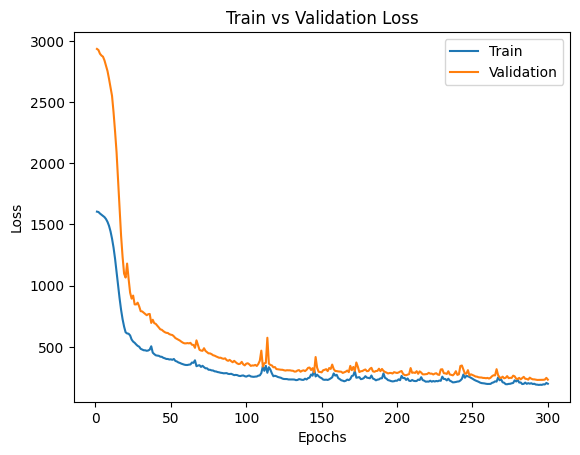

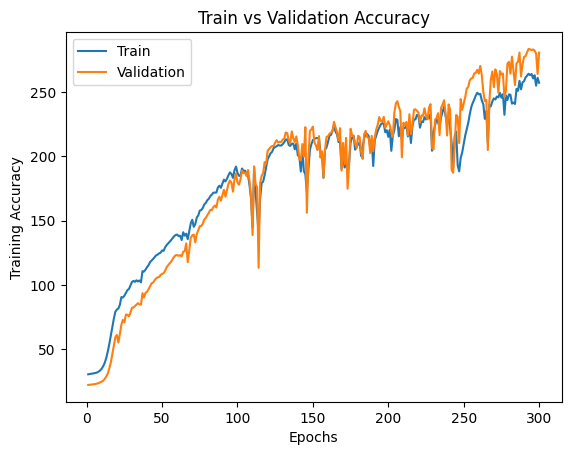

Final Training Accuracy: 257.20144975884364
Final Validation Accuracy: 280.65799238192284


In [5]:
model_4 = FirePrediction()
train(model_4, train_data, val_data, num_epochs=300, batch_size=128)